In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm.notebook import tqdm
from prophet import Prophet
#from dateutil.relativedelta import *

#자체 파일
from config import *
_cfg = config

import warnings
warnings.filterwarnings(action='ignore')

# 한글 글씨체 설정
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.grid'] = False

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)
#소수점 아래 5자리까지 표시
pd.options.display.float_format = '{: .5f}'.format

df = pd.read_csv('../Naver_Search_Amount/data/result/search_result_absolute20230214.csv', encoding='cp949') #최근파일 읽기로 바꾸기(pjmain에서)
# 시계열 그래프 작성을 위해 값이 2개 최소 이상인 검색어만 추출
df_ = df[df.columns[df.isnull().sum() < len(df)-1]]

# 이상탐지
- (Prophet) https://www.analyticsvidhya.com/blog/2021/12/anomaly-detection-model-using-facebook-prophet/
- https://mkang32.github.io/python/2020/12/15/prophet-intro.html
- (sklearn) https://github.com/uiandwe/TIL/blob/master/Machine_Running/%EC%9D%B4%EC%83%81%EA%B0%90%EC%A7%80/Anomaly_Detection_using_Isolation_Forest.ipynb
- https://john-analyst.medium.com/isolation-forest%EB%A5%BC-%ED%86%B5%ED%95%9C-%EC%9D%B4%EC%83%81%ED%83%90%EC%A7%80-%EB%AA%A8%EB%8D%B8-9b10b43eb4ac
- (RNN) https://velog.io/@jhpark/RNN-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%9D%B4%EC%83%81%EC%B9%98-%ED%83%90%EC%A7%80-%EC%BD%94%EB%93%9C-%EB%A6%AC%EB%B7%B0

## !!!!!train은 어제까지로 바꾸고, forecast에 어제부터로 해야하는거 아닌지??

In [65]:
final_df = df_.copy()
final_df['날짜'] = final_df['날짜'].astype('datetime64[ns]')
final_df = final_df.iloc[:,:20]
df_anomaly = final_df[['날짜']]
col_na = []
weight = 1.5

final_df = final_df[final_df.columns[final_df.apply(lambda x: len(x[x.notnull().values]) > 30).values == True]] # 값이 30개 이상인 항목만
for search_key in tqdm(final_df.columns[1:]): #'날짜'제외
    new_df = final_df[['날짜', search_key]]
    new_df = new_df.set_index('날짜')
    new_df_prophet = new_df.reset_index()[['날짜', new_df.columns[0]]].rename({'날짜':'ds', new_df.columns[0]:'y'}, axis='columns')
    m = Prophet()#changepoint_range=0.95, changepoint_prior_scale=0.05) #holidays=holidays)
    m.add_country_holidays(country_name='KR')
    m.fit(new_df_prophet)
    future = m.make_future_dataframe(periods=365, freq='D')
    forecast = m.predict(future)
    #new_df_prophet['ds'] = new_df_prophet['ds'].astype('datetime64[ns]')
    result = pd.concat([new_df_prophet.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
    result['error'] = result['y'] - result['yhat'] #실제값 - 예측값범위
    result['uncertainty'] = result['yhat_upper'] - result['yhat_lower'] #범위, 불확실성
    # 본래 abs를 붙여 낮게 나온 이상치도 출력하는 코드였지만, 검색어 특성상 높게 나온 지점만 산출하기 위해 abs 삭제
    #비율에 따라, 검색량이 절대적으로 적은(일정 수치 이하) 경우는 가중치를 바꾸도록??
    result['anomaly'] = result.apply(lambda x: 'Yes' if((x['error']) > weight*x['uncertainty']) else 'No', axis = 1) #원래는 1.5. 나는 0.4
    result['anomaly'] = result.apply(lambda x: 'Low' if (x['anomaly']=='Yes') & (x['y'] < 10000) else 'Yes' if (x['anomaly']=='Yes') & (x['y'] >= 1000) else 'No', axis=1) #1000 이하는 Low로
    result = result.fillna(0)
    result['label'] = [[x[0],x[-1]] for x in result.values] # 컬럼에 y,anomaly 할당
    #result_new = result[result['anomaly']=='Yes']
    #anomaly_list = list(result_new.index)
    df_temp = result['label'].reset_index().rename(columns={'ds':'날짜','label':search_key})
    df_anomaly = pd.merge(df_anomaly,df_temp, on = '날짜')
df_anomaly

  0%|          | 0/19 [00:00<?, ?it/s]

17:24:32 - cmdstanpy - INFO - Chain [1] start processing
17:24:32 - cmdstanpy - INFO - Chain [1] done processing
17:24:34 - cmdstanpy - INFO - Chain [1] start processing
17:24:35 - cmdstanpy - INFO - Chain [1] done processing
17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:38 - cmdstanpy - INFO - Chain [1] done processing
17:24:40 - cmdstanpy - INFO - Chain [1] start processing
17:24:41 - cmdstanpy - INFO - Chain [1] done processing
17:24:43 - cmdstanpy - INFO - Chain [1] start processing
17:24:44 - cmdstanpy - INFO - Chain [1] done processing
17:24:46 - cmdstanpy - INFO - Chain [1] start processing
17:24:47 - cmdstanpy - INFO - Chain [1] done processing
17:24:50 - cmdstanpy - INFO - Chain [1] start processing
17:24:50 - cmdstanpy - INFO - Chain [1] done processing
17:24:53 - cmdstanpy - INFO - Chain [1] start processing
17:24:53 - cmdstanpy - INFO - Chain [1] done processing
17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:57 - cmdstanpy - INFO - Chain [1]

,날짜,계란,포도,배,사과,망고,옥수수,벼,쌀,보리,식약처,식품의약품안전처,식품안전나라,수박,복숭아,오렌지,딸기,크릴오일,참외,양식
0,2016-01-01,"[937.4128010973376, No]","[427.50418632888704, No]","[1487.7744989179375, No]","[2495.60562977272, No]","[2017.1605240448305, No]","[719.6653417055212, No]","[157.31754520280305, No]","[737.6444897286988, No]","[1065.2645203732664, No]","[303.1484125019094, No]","[170.80190622018617, No]","[0.0, No]","[566.8425835085126, No]","[606.2968250038188, No]","[858.0048973283036, No]","[2050.621716199077, No]","[13.983781795804717, No]","[259.19938400080883, No]","[303.1484125019094, No]"
1,2016-01-02,"[791.5819337982311, No]","[420.0128746525631, No]","[1424.8474808368162, No]","[2561.0297517459494, No]","[2281.8535366082765, No]","[755.1242169734546, No]","[149.3268127480575, No]","[704.1832975744518, No]","[1557.193987118539, No]","[369.0719552535602, No]","[213.75209316444352, No]","[0.0, No]","[522.893555007412, No]","[626.7730769191043, No]","[975.8682010358004, No]","[2100.563794041237, No]","[6.9918908979023575, No]","[261.1970671144952, No]","[305.1460956155957, No]"
2,2016-01-03,"[891.4660894825507, No]","[463.9619031536636, No]","[1522.7339534074492, No]","[2855.18859023627, No]","[2383.7353754062824, No]","[877.9817284651674, No]","[159.31522831648945, No]","[925.9261231936408, No]","[1561.1893533459124, No]","[407.0279344136015, No]","[240.22139442078816, No]","[0.0, No]","[575.8321575201013, No]","[613.7881366801428, No]","[1000.3398191784588, No]","[3579.848139726007, No]","[6.9918908979023575, No]","[258.2005424439657, No]","[379.5597916004137, No]"
3,2016-01-04,"[1087.7384554022383, No]","[1008.3305516332044, No]","[1842.3632515972715, No]","[3857.526092528415, No]","[2420.1930922310594, No]","[965.8797854673686, No]","[265.192433341868, No]","[1082.7442476180224, No]","[1572.6760312496087, No]","[3174.817888426092, No]","[1210.0965461155297, No]","[0.0, No]","[1313.9760680272216, No]","[778.5969935592697, No]","[1120.7002267780638, No]","[3054.457480826487, No]","[31.463509040560613, No]","[327.62003064456763, No]","[576.8309990769445, No]"
4,2016-01-05,"[1054.2772632479912, No]","[556.354747161659, No]","[1981.701648776897, No]","[3699.70912654719, No]","[2266.8709132556287, No]","[1049.283055463775, No]","[236.72544897183695, No]","[1050.2818970206183, No]","[1473.7907171221327, No]","[3159.3358442950225, No]","[1370.9100367672836, No]","[0.0, No]","[728.65491571711, No]","[801.0709285882415, No]","[1099.2251333059348, No]","[2876.164262929977, No]","[17.979148023177494, No]","[331.6153968719404, No]","[562.8472172811398, No]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596,2023-02-09,"[1432.8382132915615, No]","[1030.804486662176, No]","[1787.4269659708957, No]","[4576.192592677094, No]","[3827.061425044698, No]","[1255.044416173473, No]","[211.25498927233556, No]","[1639.5984155581027, No]","[644.2528041638601, No]","[2727.836291738763, No]","[978.86472570633, No]","[3030.9847042406723, No]","[1280.5148758729747, No]","[1437.8324210757778, No]","[1630.608841546514, No]","[4553.718657648121, No]","[391.545890282532, No]","[1421.8509561662866, No]","[951.3965828931424, No]"
2597,2023-02-10,"[1280.5148758729747, No]","[1041.2923230090298, No]","[1635.6030493307303, No]","[4035.819310424926, No]","[3342.623269975749, No]","[1239.5623720424037, No]","[188.28163346494205, No]","[1546.2067299932644, No]","[660.2342690733512, No]","[2391.726107861028, No]","[821.0477597251054, No]","[2475.1293778574345, No]","[1244.5565798266198, No]","[1347.437260181469, No]","[1595.6493870570023, No]","[4461.325813640126, No]","[340.6049708835291, No]","[1516.2414832879683, No]","[1042.2911645658728, No]"
2598,2023-02-11,"[1091.7338216296112, No]","[1086.739613845395, No]","[1583.663288374884, No]","[3646.770524034501, No]","[3834.0533159426, No]","[1203.1046552176272, No]","[192.2769996923149, No]","[1450.3179405363176, No]","[625.774235362261, No]","[538.3755991384816, No]","[312.13798651349816, No]","[590.

In [532]:
anomaly_list = []
low_list = []
for i in range(len(df_anomaly)):
    if 'Yes' in [x[1] for x in df_anomaly.iloc[:,1:].values[i]]:
        #print(sum(df_anomaly.iloc[:,1:].values[i]))
        anomaly_list.append(final_df['날짜'][i])
    elif 'Low' in [x[1] for x in df_anomaly.iloc[:,1:].values[i]]:
        low_list.append(final_df['날짜'][i])

In [533]:
anomaly_list = pd.DataFrame(anomaly_list, columns=['날짜'])
df_anomaly_yes = pd.merge(anomaly_list, df_anomaly, how='inner', on='날짜')

In [534]:
df_anomaly_yes['날짜'] = df_anomaly_yes['날짜'].astype('string')

In [535]:
df_anomaly_yes = df_anomaly_yes.set_index('날짜')

# 날짜가 key(어제 날짜 뽑을 때 사용!)
df_anomaly_dict = {}
for i in range(len(df_anomaly_yes)):
    temp_list = []
    for j in range(len(df_anomaly_yes.iloc[i])):
        if df_anomaly_yes.iloc[i][j][1] == 'Yes':
            temp_list.append(df_anomaly_yes.columns[j])
            #print(df_anomaly_yes.index[i],df_anomaly_yes.columns[j])
        df_anomaly_dict[df_anomaly_yes.index[i]] = temp_list

In [503]:
# 검색어가 key
df_anomaly_dict = {}
for i in range(len(df_anomaly_yes.columns)):
    temp_list = []
    for j in range(len(df_anomaly_yes.iloc[:,i])):
        if df_anomaly_yes.iloc[j][i][1] == 'Yes':
            temp_list.append(df_anomaly_yes.index[j])
            #print(df_anomaly_yes.index[i],df_anomaly_yes.columns[j])
        df_anomaly_dict[df_anomaly_yes.columns[i]] = temp_list

In [548]:
df_anomaly_key = pd.DataFrame(df_anomaly_dict.items(), columns=['검색어', '날짜'])

# 히트맵

for i in range(len(df_anomaly.values)):
    for j in range(1, len(df_anomaly.values[i])):
        if df_anomaly.values[i][j] == 'No':
            df_anomaly.iloc[i][j] = 1
        elif df_anomaly.values[i][j] == 'Low':
            df_anomaly.iloc[i][j] = 0
        elif df_anomaly.values[i][j] == 'Yes':
            df_anomaly.iloc[i][j] = 2

In [287]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [288]:
df_anomaly.iloc[:,1:].shape

(2595, 19)

In [289]:
ori = df_anomaly.iloc[:,1:].copy()

In [290]:
ori = ori.values.reshape((-1, 1))
orile = le.fit_transform(ori)

In [291]:
ori_shape = df_anomaly.iloc[:,1:].shape
ori = ori.reshape(ori_shape)
orile = orile.reshape(ori_shape)

In [293]:
df = pd.DataFrame(orile, columns=df_anomaly.iloc[:,1:].columns)
df = pd.concat([final_df['날짜'], df],axis=1)
df['날짜'] = df['날짜'].astype('string')

In [312]:
df['식품안전나라'].value_counts()

1    2589
2       6
Name: 식품안전나라, dtype: int64

In [300]:
#방법1(예측 불확실성..)
result[result['anomaly'] != 'No']

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2020-04-12,2855.38752,730.29139,627.33213,835.86791,2125.09613,208.53578,Low
2020-04-13,1154.04826,818.72591,710.77343,919.33809,335.32235,208.56466,Low
2020-04-18,1337.99045,685.66498,585.55163,793.77931,652.32546,208.22768,Low
2020-04-20,1252.82269,814.71254,710.83944,917.56158,438.11016,206.72214,Low
2020-04-21,1251.81479,809.90299,710.17065,910.20941,441.91180,200.03876,Low
2020-04-23,1208.47499,796.67211,699.48072,898.59327,411.80288,199.11255,Low
2021-12-24,1268.44518,827.57819,721.93027,925.31533,440.86699,203.38506,Low
2021-12-25,1506.81410,1084.48407,982.90407,1187.17071,422.33003,204.26664,Low
2022-12-24,1835.39029,860.63033,761.28993,955.77318,974.75996,194.48325,Low


In [301]:
#방법2(error가 크면)
result[result['anomaly'] != 'No']['error']/result[result['anomaly'] != 'No']['yhat'].max()

ds
2020-04-12    1.70226
2020-04-13    0.26860
2020-04-18    0.52253
2020-04-20    0.35094
2020-04-21    0.35398
2020-04-23    0.32987
2021-12-24    0.35315
2021-12-25    0.33830
2022-12-24    0.78081
2022-12-25    0.85087
Name: error, dtype: float64

In [429]:
anomaly_list = []
for i in range(len(df)):
    if sum(df.iloc[:,1:].values[i]) > (len(df.columns)-1):
        #print(sum(df.iloc[:,1:].values[i]))
        anomaly_list.append(df['날짜'][i])

In [474]:
anomaly_list = pd.DataFrame(anomaly_list, columns=['날짜'])
df = pd.merge(anomaly_list, df, how='inner', on='날짜')

In [477]:
import seaborn as sns

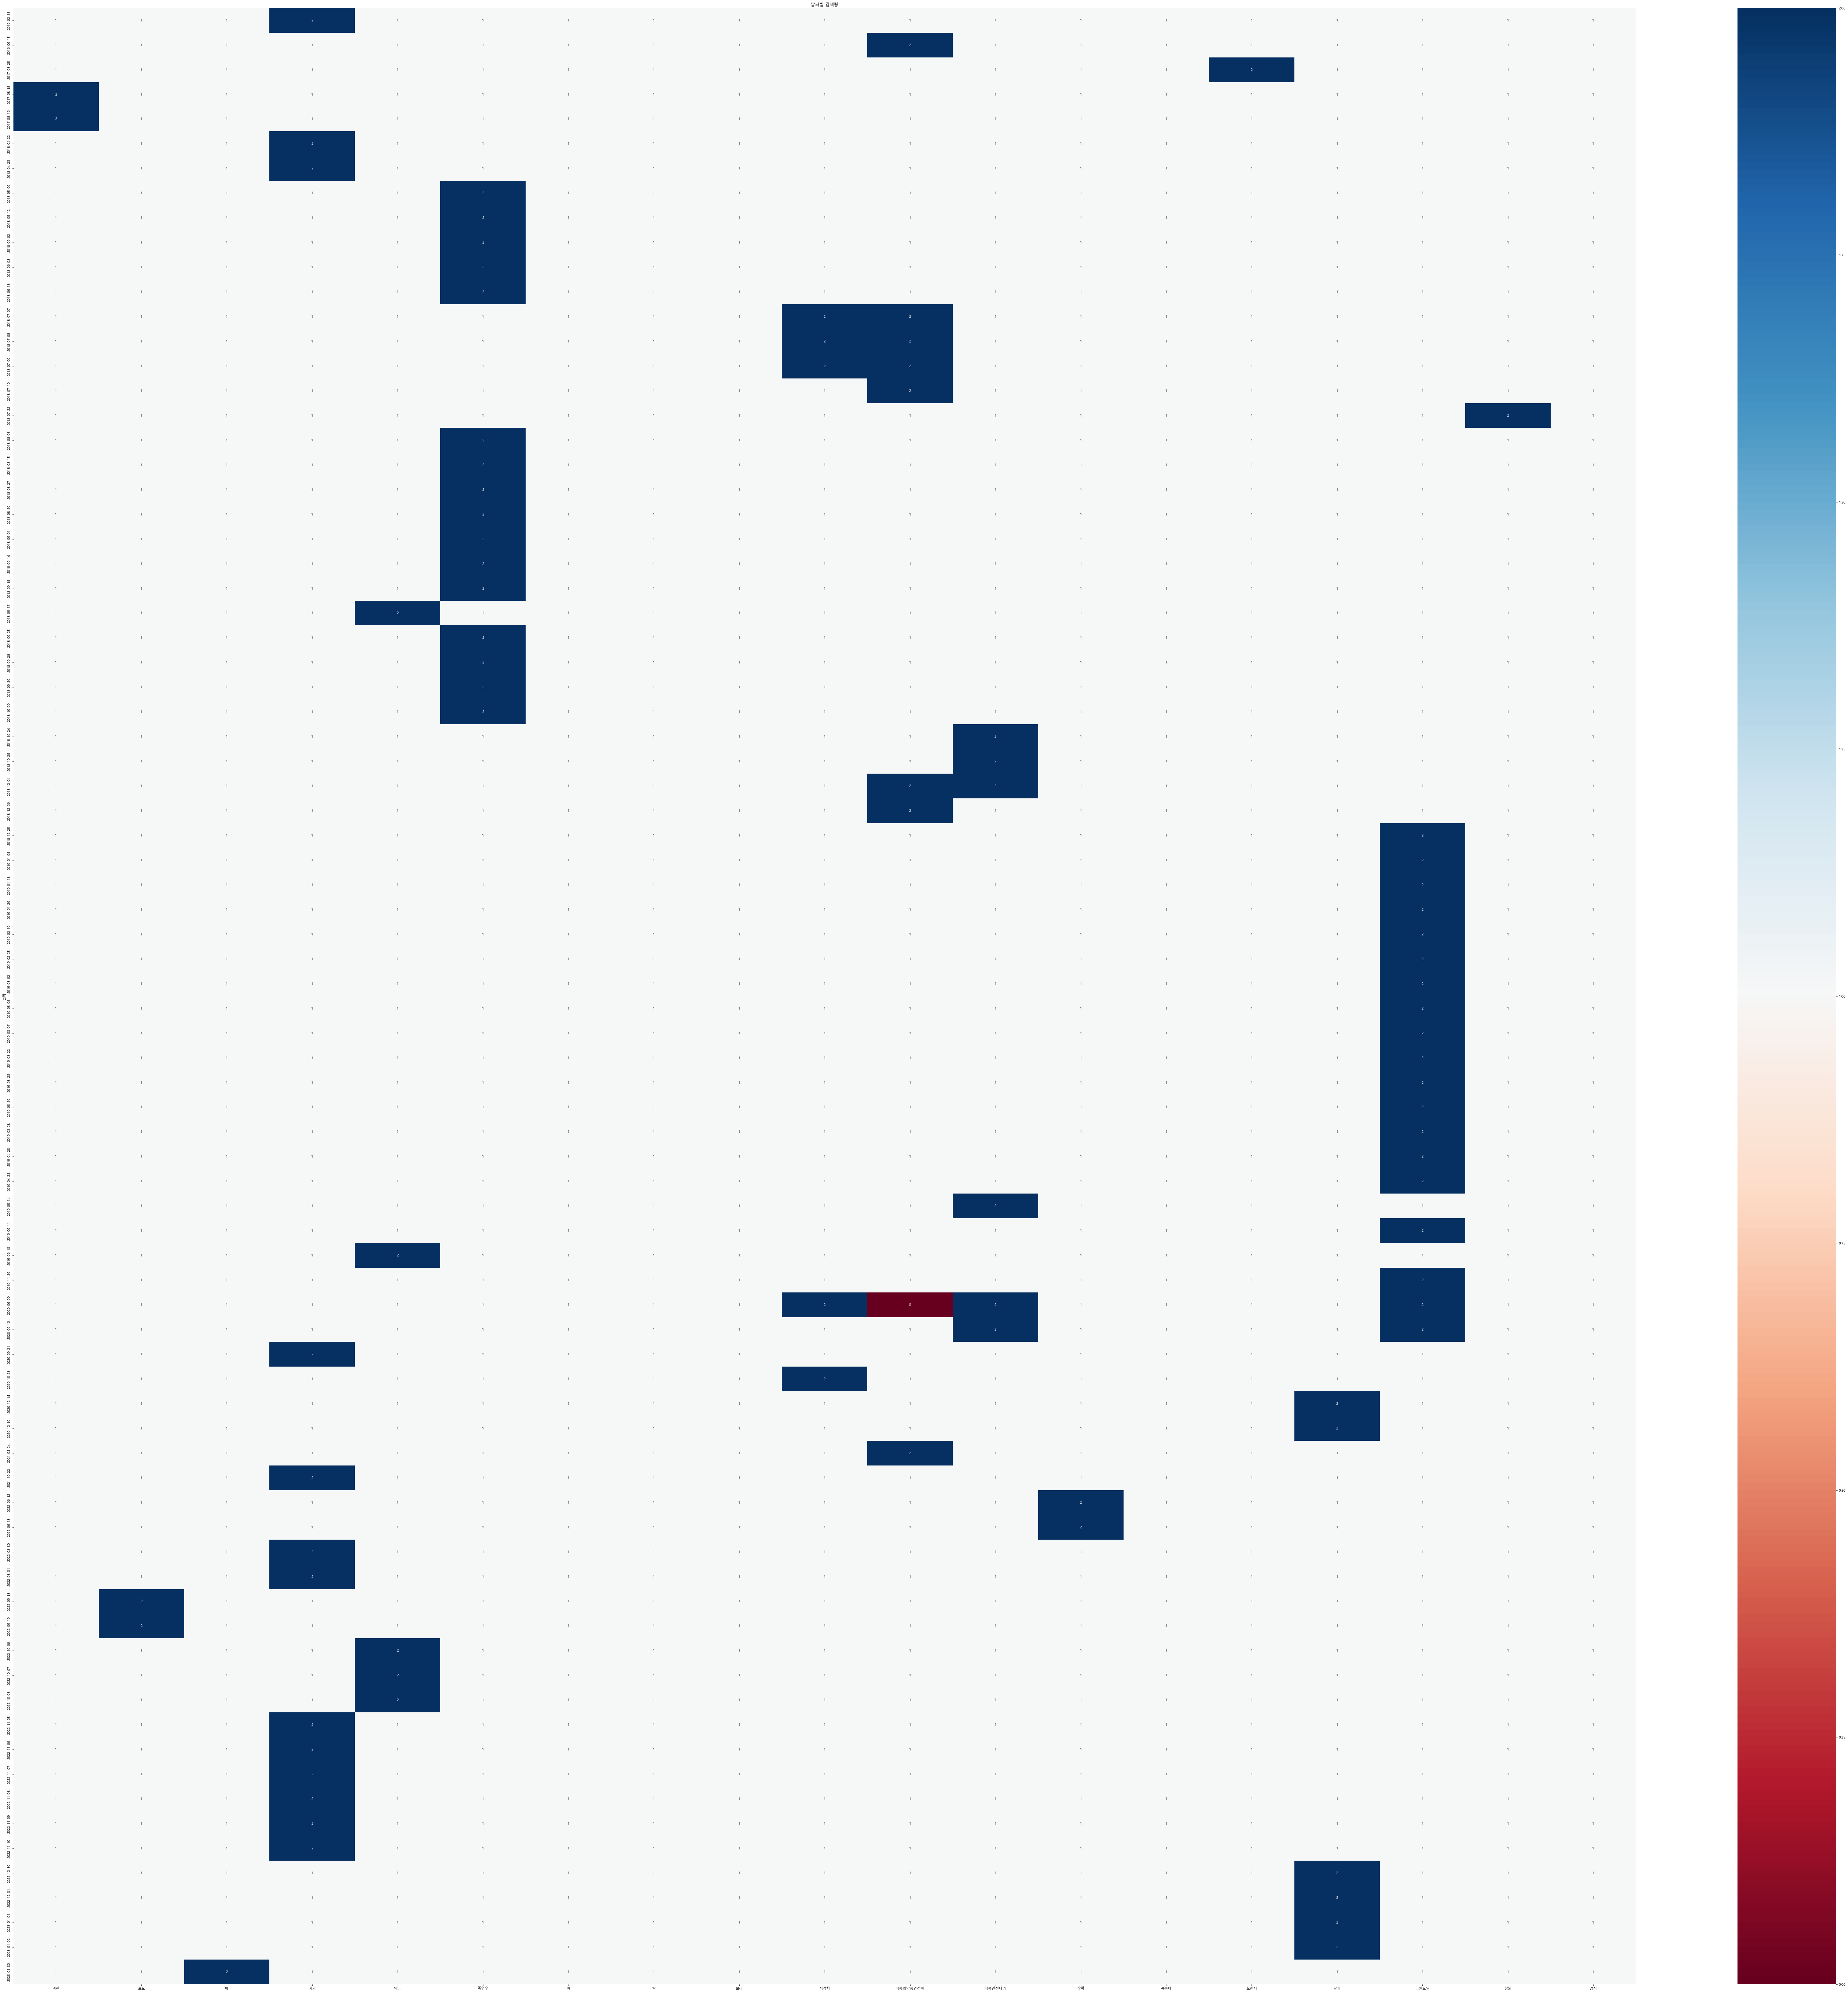

In [481]:
df_ = df.set_index('날짜')
plt.figure(figsize = (100,100))
sns.heatmap(df_, annot=True, fmt='d', cmap='RdBu')
plt.title('날짜별 검색량')
plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

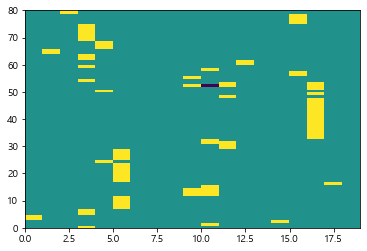

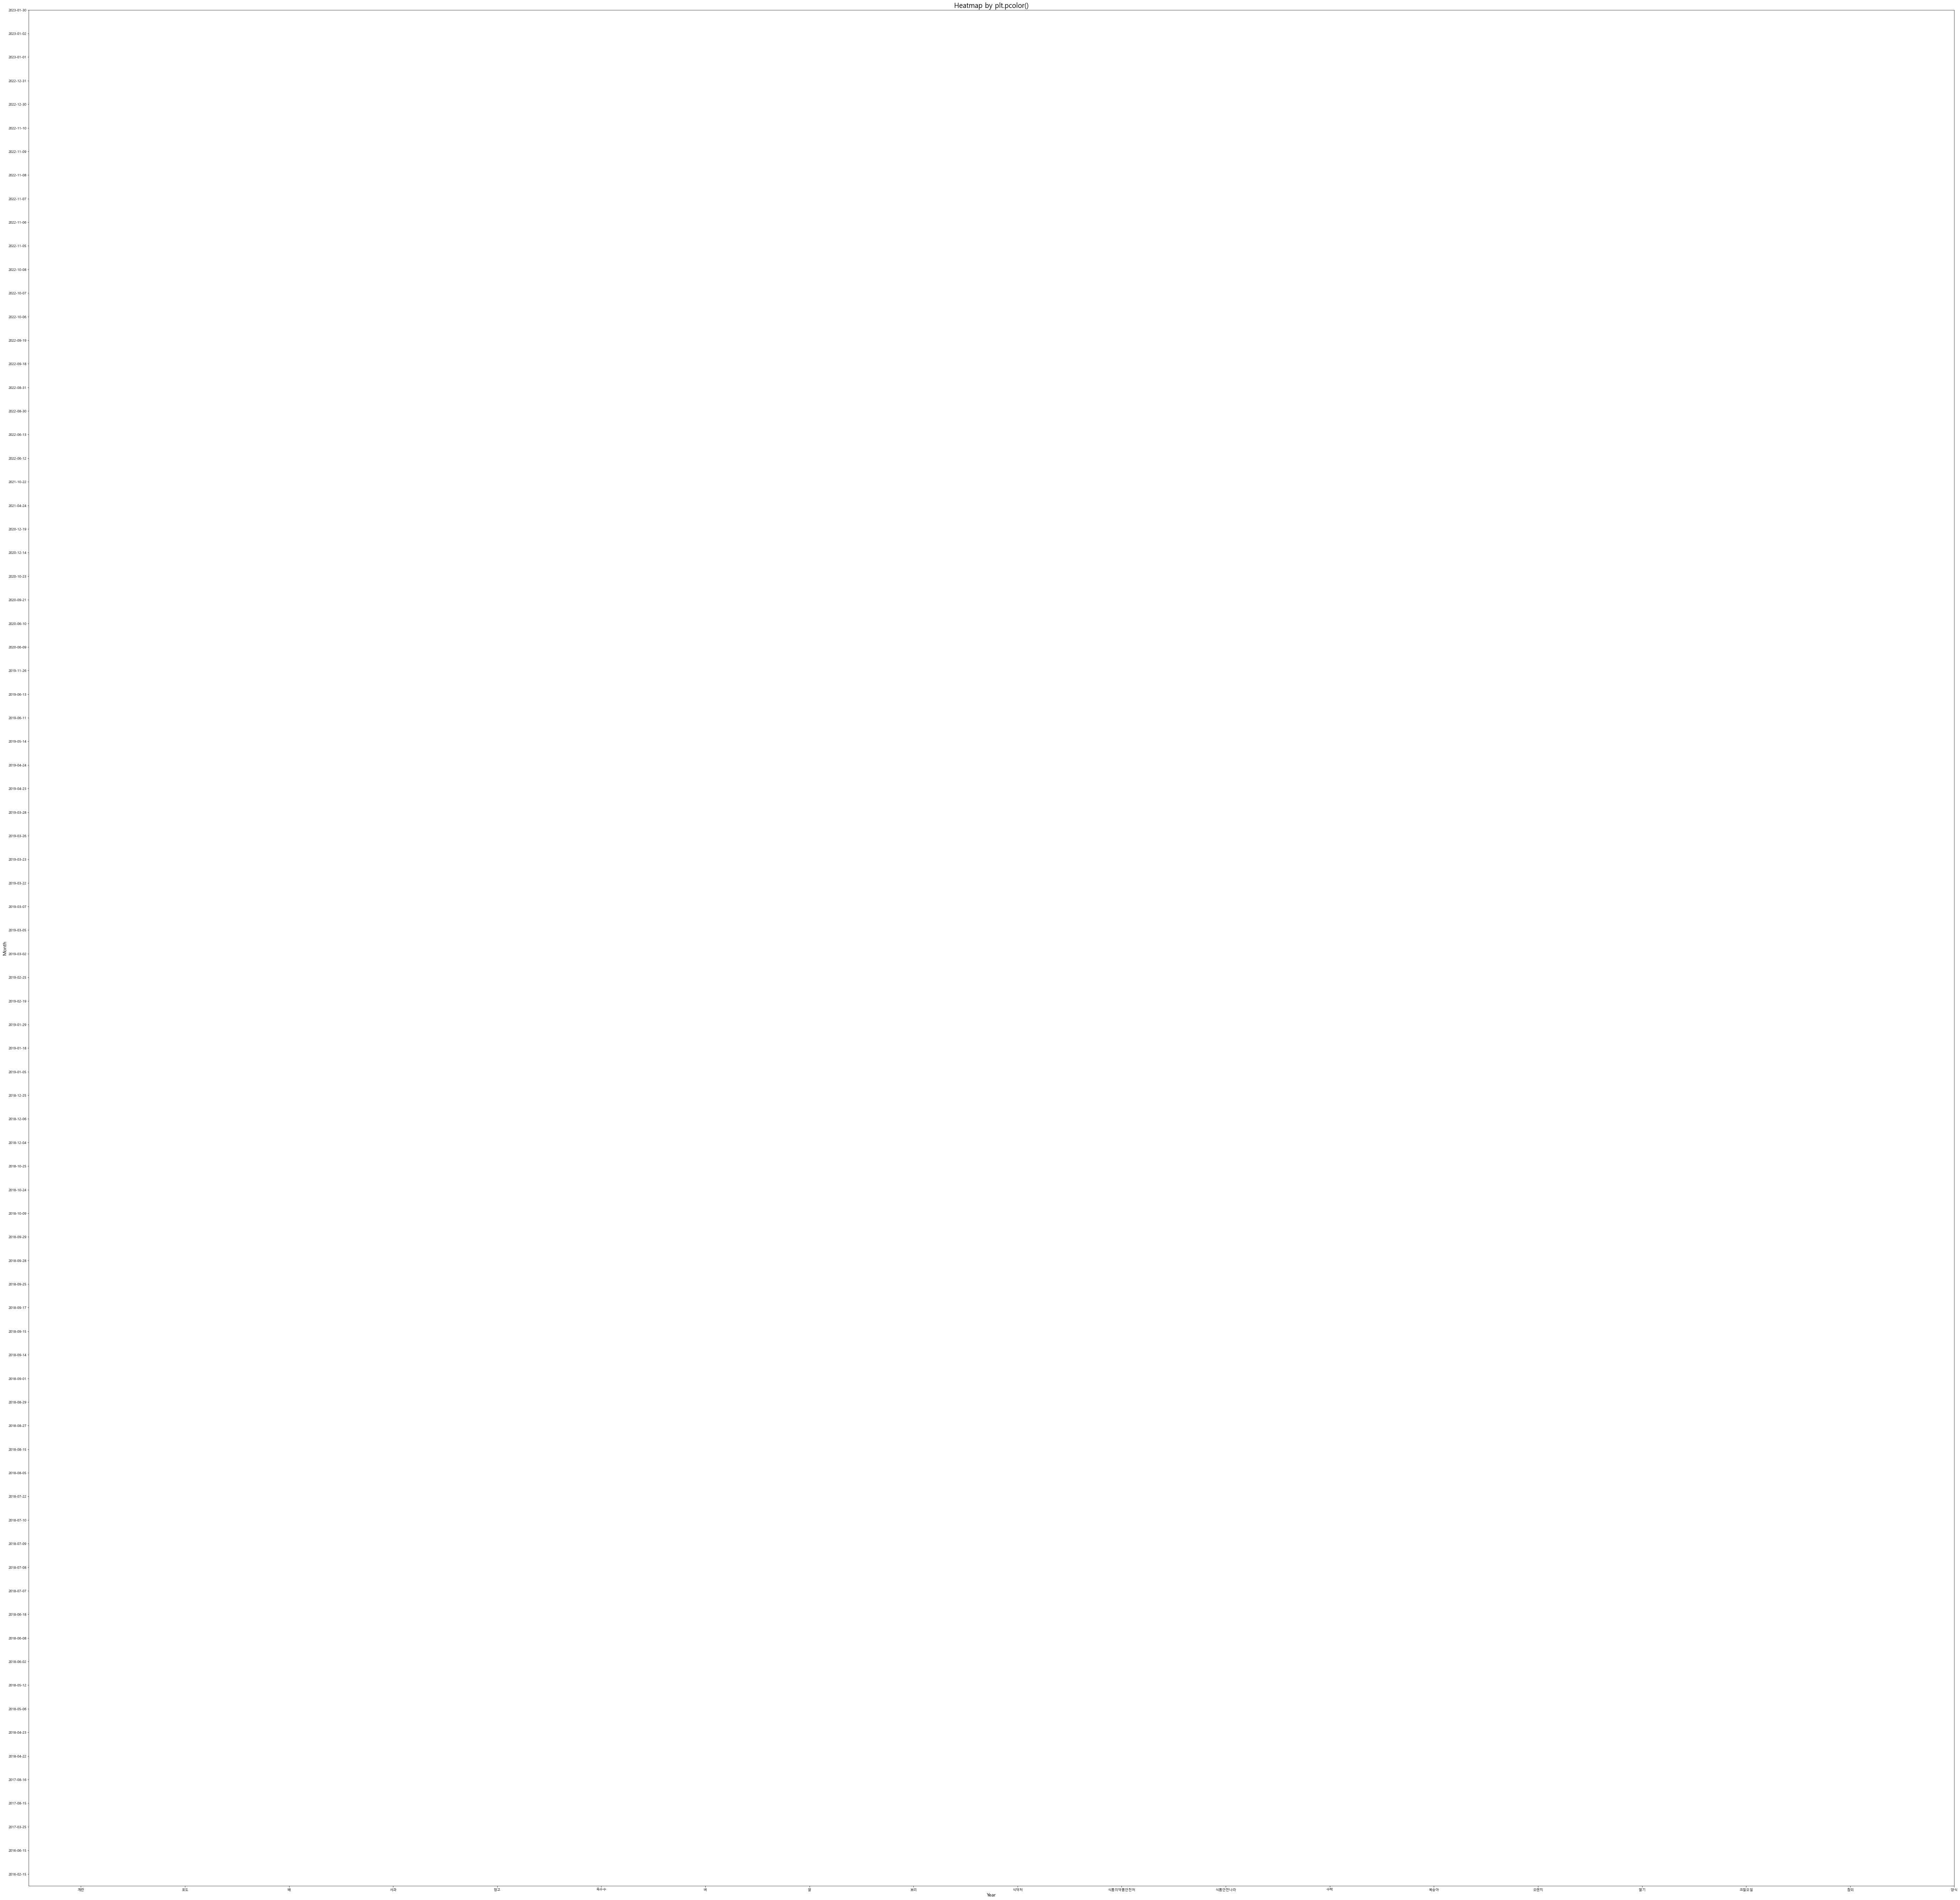

In [484]:
# heatmap by plt.pcolor()
plt.pcolor(df_)
plt.xticks(np.arange(0.5, len(df_.columns), 1), df_.columns)
plt.yticks(np.arange(0.5, len(df_.index), 1), df_.index)
plt.title('Heatmap by plt.pcolor()', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Month', fontsize=14)
plt.colorbar()
plt.show()

In [272]:
def key_date(df_anomaly_yes):
    # 날짜가 key(어제 날짜 뽑을 때 사용!)
    df_anomaly_dict = {}
    for i in range(len(df_anomaly_yes)):
        temp_list = []
        for j in range(len(df_anomaly_yes.iloc[i])):
            if df_anomaly_yes.iloc[i][j][1] == 'Yes':
                temp_list.append(df_anomaly_yes.columns[j])
                #print(df_anomaly_yes.index[i],df_anomaly_yes.columns[j])
            df_anomaly_dict[df_anomaly_yes.index[i]] = temp_list
    return pd.DataFrame(df_anomaly_dict.items(), columns=['날짜','검색어'])

In [273]:
df_anomaly_ = key_date(df_anomaly_yes)

In [274]:
df_anomaly_['날짜'].iloc[-1]

'2023-01-30'

In [276]:
df_anomaly_.T.values[0]

array(['2016-02-15', '2016-06-15', '2017-03-25', '2017-08-15',
       '2017-08-16', '2018-04-22', '2018-04-23', '2018-05-06',
       '2018-05-12', '2018-06-08', '2018-06-18', '2018-06-27',
       '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
       '2018-07-22', '2018-08-05', '2018-08-15', '2018-08-27',
       '2018-08-29', '2018-09-01', '2018-09-14', '2018-09-15',
       '2018-09-17', '2018-09-25', '2018-09-28', '2018-09-29',
       '2018-09-30', '2018-10-09', '2018-10-24', '2018-10-25',
       '2018-12-04', '2018-12-06', '2018-12-25', '2019-01-05',
       '2019-01-18', '2019-01-29', '2019-02-19', '2019-02-25',
       '2019-03-02', '2019-03-05', '2019-03-07', '2019-03-22',
       '2019-03-23', '2019-03-26', '2019-03-28', '2019-04-23',
       '2019-04-24', '2019-05-14', '2019-06-13', '2019-10-15',
       '2019-10-16', '2019-11-26', '2020-03-09', '2020-06-09',
       '2020-06-10', '2020-09-14', '2020-09-21', '2020-10-15',
       '2020-10-23', '2020-12-14', '2020-12-19', '2021-

In [282]:
#yesterday = '2023-01-30'

In [283]:
# 어제 이상치 추출(어제)
from datetime import datetime
df_anomaly_ = key_date(df_anomaly_yes)

yesterday = str(datetime.now().date() - relativedelta(days=1))
if df_anomaly_['날짜'].iloc[-1] == yesterday:
    anomaly_yesterday = df_anomaly_[df_anomaly_['날짜'] == yesterday]['검색어'].values[0] #어제 이상치..
    message = f'{df_anomaly_.날짜.iloc[-1]} 이상검색어 목록입니다. \n{anomaly_yesterday}'
else:
    message = f'{df_anomaly_.날짜.iloc[-1]} 이후 발견된 이상 검색어가 없습니다.'
print(message)

2023-01-30 이상검색어 목록입니다. 
['배']


# 시각화

In [62]:
### vscode에서는 실행불가. jupyter를 이용하는 것을 권장 ###

# 라이브러리
import pandas as pd
import plotly.express as px
from prophet import Prophet

import warnings
warnings.filterwarnings(action='ignore')

df_anomaly = pd.read_csv('../Naver_Search_Amount/data/result/search_result_absolute20230214.csv', encoding='cp949')
df_anomaly = df_anomaly[df_anomaly.columns[df_anomaly.apply(lambda x: len(x[x.notnull().values]) > 30).values == True]] # 값이 30개 이상인 항목만
weight = 1.5  #가중치 직접 설정가능 (오차 허용범위(높을 수록 둔감))

def visualization(df_anomaly):
    search_key = input('검색어를 입력해주세요: ')
    if search_key not in df_anomaly.columns:
        return print('해당 검색어는 이상감지 목표 검색어에 해당하지 않습니다. config 파일에 추가 후 재실행 해주십시오.')
    new_df = df_anomaly[['날짜', search_key]]
    new_df['날짜'] = new_df['날짜'].astype('datetime64[ns]')
    new_df = new_df.set_index('날짜')
    new_df_prophet = new_df.reset_index()[['날짜', new_df.columns[0]]].rename({'날짜':'ds', new_df.columns[0]:'y'}, axis='columns')
    m = Prophet()#changepoint_range=0.95, changepoint_prior_scale=0.05) #holidays=holidays)
    m.add_country_holidays(country_name='KR')
    m.fit(new_df_prophet)
    future = m.make_future_dataframe(periods=365, freq='D')
    forecast = m.predict(future)
    forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10)
    result = pd.concat([new_df_prophet.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
    result['error'] = result['y'] - result['yhat'] #실제값 - 예측값범위
    result['uncertainty'] = result['yhat_upper'] - result['yhat_lower'] #범위, 불확실성
    # 본래 abs를 붙여 낮게 나온 이상치도 출력하는 코드였지만, 검색어 특성상 높게 나온 지점만 산출하기 위해 abs 삭제
    #비율에 따라, 검색량이 절대적으로 적은(일정 수치 이하) 경우는 가중치를 바꾸도록??
    result['anomaly'] = result.apply(lambda x: 'Yes' if((x['error']) > weight*x['uncertainty']) else 'No', axis = 1) #원래는 1.5. 나는 0.4
    result['anomaly'] = result.apply(lambda x: 'Low' if (x['anomaly']=='Yes') & (x['y'] < 10000) else 'Yes' if (x['anomaly']=='Yes') & (x['y'] >= 10000) else 'No', axis=1) #10000 이하는 Low로
    #visualize the anomaly data
    fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', 
                     color_discrete_map={'Yes': '#EF553B','No': '#636EFA', 'Low': '#00CC96'}, title=new_df.columns[0])    
    #slider
    fig.update_xaxes(
        rangeslider_visible = True,
        rangeselector = dict(
            buttons = list([
                    dict(count=1, label='1y', step="year", stepmode="backward"),
                    dict(count=2, label='3y', step="year", stepmode="backward"),
                    dict(count=2, label='5y', step="year", stepmode="backward"),
                    dict(step="all")
            ])
        )
    )
    fig.show()
visualization(df_anomaly)

검색어를 입력해주세요: 사과


17:19:30 - cmdstanpy - INFO - Chain [1] start processing
17:19:31 - cmdstanpy - INFO - Chain [1] done processing


# 저장한 데이터를 이용해 그래프를 그릴 경우 사용(추후 추가)
df_anomaly = pd.read_csv('data/Anomaly_result.csv', encoding='cp949')

In [927]:
weight = 1.5 # 오차 허용범위(높을 수록 둔감)

for search_key in anomaly_yesterday:
    new_df = final_df[['날짜', search_key]]
    new_df = new_df.set_index('날짜')
    new_df_prophet = new_df.reset_index()[['날짜', new_df.columns[0]]].rename({'날짜':'ds', new_df.columns[0]:'y'}, axis='columns')
    m = Prophet()#changepoint_range=0.95, changepoint_prior_scale=0.05) #holidays=holidays)
    m.add_country_holidays(country_name='KR')
    m.fit(new_df_prophet)
    future = m.make_future_dataframe(periods=365, freq='D')
    forecast = m.predict(future)
    forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10)
    result = pd.concat([new_df_prophet.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
    result['error'] = result['y'] - result['yhat'] #실제값 - 예측값범위
    result['uncertainty'] = result['yhat_upper'] - result['yhat_lower'] #범위, 불확실성
    # 본래 abs를 붙여 낮게 나온 이상치도 출력하는 코드였지만, 검색어 특성상 높게 나온 지점만 산출하기 위해 abs 삭제
    #비율에 따라, 검색량이 절대적으로 적은(일정 수치 이하) 경우는 가중치를 바꾸도록??
    result['anomaly'] = result.apply(lambda x: 'Yes' if((x['error']) > weight*x['uncertainty']) else 'No', axis = 1) #원래는 1.5. 나는 0.4
    result['anomaly'] = result.apply(lambda x: 'Low' if (x['anomaly']=='Yes') & (x['y'] < 1000) else 'Yes' if (x['anomaly']=='Yes') & (x['y'] >= 1000) else 'No', axis=1) #1000 이하는 Low로
    #result_new = result[result['anomaly']=='Yes']
    #visualize the anomaly data
    fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title=new_df.columns[0])
    #slider
    fig.update_xaxes(
        rangeslider_visible = True,
        rangeselector = dict(
            buttons = list([
                  dict(count=1, label='1y', step="year", stepmode="backward"),
                  dict(count=2, label='3y', step="year", stepmode="backward"),
                  dict(count=2, label='5y', step="year", stepmode="backward"),
                  dict(step="all")
            ])
        )
    )
    fig.show()

16:03:46 - cmdstanpy - INFO - Chain [1] start processing
16:03:46 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# 외부링크

In [48]:
from bokeh.plotting import figure, output_file, show
p = figure(title=new_df.columns[0], x_axis_label = 'ds', y_axis_label = 'y')
p.circle(result.reset_index()['ds'],[result[result.reset_index()['anomaly'].values == 'No']['y'], result[result.reset_index()['anomaly'].values == 'Yes']['y']], color=['blue','red'])

#p.circle(result.reset_index()['ds'],result[result.reset_index()['anomaly'].values == 'No']['y'], color='blue')
#p.scatter(result.reset_index()['ds'],result[result.reset_index()['anomaly'].values == 'Yes']['y'], color='red')
show(p)

In [49]:
import plotly.express as px
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title=new_df.columns[0])
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()
fig.write_html("data/visualization.html")

In [420]:
from config import *
_cfg = config

In [423]:
# 카카오 API
# -https://developers.kakao.com/tool/rest-api/open/post/v2-api-talk-memo-default-send
import json
import requests

from datetime import datetime
from dateutil.relativedelta import relativedelta

# 자체 파일
from config import *
_cfg = config
def kakao_send_text(message):
    url = "https://kapi.kakao.com/v2/api/talk/memo/default/send"
    # 사용자 토큰
    headers = {
        "Authorization": "Bearer " + _cfg['Kakao_api']['Kakao_Authorization']
    }
    data = {
        "template_object" : json.dumps({ "object_type" : "text",
                                        "text" : message,
                                        "link" : {
                                                    "web_url" : "www.naver.com",
                                                    "mobile_web_url": "https://developers.kakao.com"
                                                }
        })
    }
    response = requests.post(url, headers=headers, data=data)
    print(response.status_code)
    if response.json().get('result_code') == 0:
        print('메시지를 성공적으로 보냈습니다.')
    else:
        print('메시지를 성공적으로 보내지 못했습니다. 오류메시지 : ' + str(response.json()))
        # 이미지 보내는 방법 추가 필요

In [424]:
yesterday = str(datetime.now().date() - relativedelta(days=1))
if df_anomaly_date['날짜'].iloc[-1] == yesterday:
    anomaly_yesterday = df_anomaly_date[df_anomaly_date['날짜'] == yesterday]['검색어'].values[0] #어제 이상치..
    message = f'{df_anomaly_date.날짜.iloc[-1]} 이상검색어 목록입니다. \n{anomaly_yesterday}'
else:
    message = f'{df_anomaly_date.날짜.iloc[-1]} 이후 발견된 이상 검색어가 없습니다.'
kakao_send_text(message)

200
메시지를 성공적으로 보냈습니다.


In [ ]:
# 카카오 API
# -https://developers.kakao.com/tool/rest-api/open/post/v2-api-talk-memo-default-send
import json
import requests

url = "https://kapi.kakao.com/v2/api/talk/memo/default/send"
# 사용자 토큰
headers = {
    "Authorization": "Bearer " + _cfg['Kakao_Authorization']
}
data = {
    "template_object" : json.dumps({ "object_type" : "text",
                                     "text" : f'{str(datetime.now().date() - relativedelta(days=1))} 이상검색어 목록입니다. {list(anomaly_yesterday)}',
                                     "link" : {
                                                 "web_url" : "www.naver.com",
                                                 "mobile_web_url": "https://developers.kakao.com"
                                              }
    })
}
response = requests.post(url, headers=headers, data=data)
print(response.status_code)
if response.json().get('result_code') == 0:
    print('메시지를 성공적으로 보냈습니다.')
else:
    print('메시지를 성공적으로 보내지 못했습니다. 오류메시지 : ' + str(response.json()))
    # 이미지 보내는 방법 추가 필요

# 이메일
- https://www.infoking.site/138

In [ ]:
import smtplib
from email.message import EmailMessage

# STMP 서버의 url과 port 번호
SMTP_SERVER = 'smtp.gmail.com'
SMTP_PORT = 465

# 1. SMTP 서버 연결
smtp = smtplib.SMTP_SSL(SMTP_SERVER, SMTP_PORT)

EMAIL_ADDR = config.ID
EMAIL_PASSWORD = config.PASSWORD

# 2. SMTP 서버에 로그인
smtp.login(EMAIL_ADDR, EMAIL_PASSWORD)

# 3. MIME 형태의 이메일 메세지 작성
message = EmailMessage()
message.set_content('이메일 본문')
message["Subject"] = "이메일 제목"
message["From"] = EMAIL_ADDR  #보내는 사람의 이메일 계정
message["To"] = '받는 사람의 이메일 계정'

# 4. 서버로 메일 보내기
smtp.send_message(message)

# 5. 메일을 보내면 서버와의 연결 끊기
smtp.quit()

In [ ]:
# 사진첨부
import imghdr #이미지 첨부를 위한 라이브러리
import smtplib
from email.message import EmailMessage

# STMP 서버의 url과 port 번호
SMTP_SERVER = 'smtp.gmail.com'
SMTP_PORT = 465

# 1. SMTP 서버 연결
smtp = smtplib.SMTP_SSL(SMTP_SERVER, SMTP_PORT)

EMAIL_ADDR = '본인의 이메일 계정'
EMAIL_PASSWORD = '본인의 이메일 계정 비밀번호'

# 2. SMTP 서버에 로그인
smtp.login(EMAIL_ADDR, EMAIL_PASSWORD)

# 3. MIME 형태의 이메일 메세지 작성
message = EmailMessage()
message.set_content('이메일 본문')
message["Subject"] = "이메일 제목"
message["From"] = EMAIL_ADDR  #보내는 사람의 이메일 계정
message["To"] = '받는 사람의 이메일 계정'

# 3-1. 이메일에 사진 첨부하기
with open('사진경로', 'rb') as image:
  image_file = image.read() # 이미지 파일 읽어오기

image_type = imghdr.what('e-mail', image_file)
message.add_attachment(image_file, maintype = 'image', subtype = image_type)


# 4. 서버로 메일 보내기
smtp.send_message(message)

# 5. 메일을 보내면 서버와의 연결 끊기
smtp.quit()

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

#검색 키워드 설정
search_key = '포도'
new_df = final_df[['날짜', search_key]]
new_df.shape

(2601, 2)

In [294]:
#df['timestamp'] = pd.to_datetime(df['timestamp'])
#df = df.set_index('timestamp').resample('H').mean().reset_index()
new_df = new_df.set_index('날짜')
new_df.shape

(2601, 1)

In [295]:
#express to plot entire data
fig = px.line(new_df.reset_index(), x='날짜', y=new_df.columns[0], title=new_df.columns[0])
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='2y', step="year", stepmode="backward"),
              dict(count=5, label='5y', step="year", stepmode="backward")
        ])
    )
)
fig.show()

In [296]:
from prophet import Prophet
new_df_prophet = new_df.reset_index()[['날짜', new_df.columns[0]]].rename({'날짜':'ds', new_df.columns[0]:'y'}, axis='columns')
# 상한하한 (그러나 전체적으로 예측치가 올라가 이상탐지에 적합하지않아서 제외)
#new_df_prophet['cap']=train.max()['y']
#new_df_prophet['floor']=0

#train test split
train = new_df[(new_df['ds'] >= '2016-01-01') & (new_df['ds'] <= '2021-12-31')]
test = new_df[(new_df['ds'] >= '2022-01-01')]

In [297]:
#Prophet(holidays=holidays로 추가 가능)
event1 = pd.DataFrame({
  'holiday': 'event1',
  'ds': pd.to_datetime(['2017-08-15', '2017-08-16']),#, "2018-08-14", '2018-08-15', '2018-08-16']),
  'lower_window': 0,
  'upper_window': 120,
})
"""
event2 = pd.DataFrame({
  'holiday': 'event2',
  'ds': pd.to_datetime(["2018-10-25", "2018-10-24"]),
  'lower_window': 0,
  'upper_window': 1,
})
"""
holidays = event1
#holidays = pd.concat((event1, event2))

In [298]:
m = Prophet()#(growth='logistic'--상하한)#changepoint_range=0.95, changepoint_prior_scale=0.05) #holidays=holidays)
m.add_country_holidays(country_name='KR')
m.fit(new_df_prophet) # train test 분리 안 하고 전체 넣어도 될 듯? (원래는 train이였음)-2022년에 사건이 있는 경우 train으로 하는게 좋음

11:32:56 - cmdstanpy - INFO - Chain [1] start processing
11:32:57 - cmdstanpy - INFO - Chain [1] done processing


In [299]:
future = m.make_future_dataframe(periods=365, freq='D')
#future['cap']=500
#future['floor']=0 #하한지정

In [300]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
2956,2024-02-04,1743.46825,564.03269,2961.87719
2957,2024-02-05,1724.93674,550.39934,2886.98475
2958,2024-02-06,1727.17875,439.70363,2943.93139
2959,2024-02-07,1692.72750,618.48347,2879.61891
2960,2024-02-08,1668.82685,504.25534,2805.24756
2961,2024-02-09,1575.71598,369.34690,2710.30143
2962,2024-02-10,1622.21611,462.15483,2850.60345
2963,2024-02-11,1652.95004,447.38776,2837.09090
2964,2024-02-12,1668.62464,458.80494,2912.14748
2965,2024-02-13,1741.49967,441.11545,2925.86803


In [301]:
#holiday 가중치 확인
forecast[['ds', 'holidays']].sort_values(by='holidays', ascending=False)#[forecast['ds'] == '2017-11-11']

,ds,holidays
2054,2021-08-16,846.42059
647,2017-10-09,326.14643
1377,2019-10-09,326.14643
2108,2021-10-09,326.14643
1743,2020-10-09,326.14643
...,...,...
2829,2023-09-30,-713.10225
1736,2020-10-02,-713.10225
641,2017-10-03,-785.36354
2446,2022-09-12,-832.22217


[[<matplotlib.lines.Line2D at 0x1b712d26c40>],

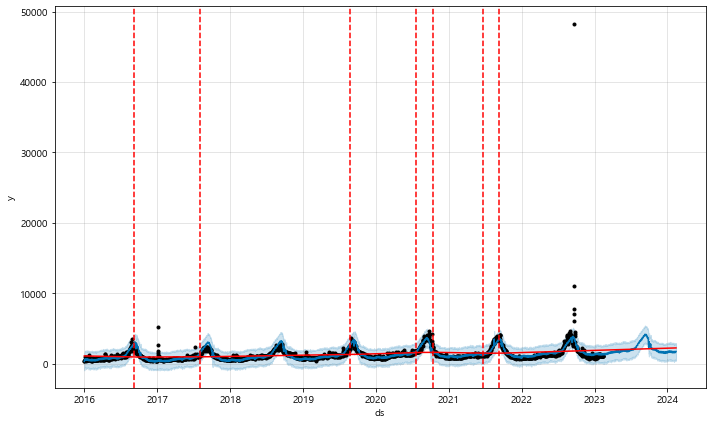

In [302]:
#change_point 탐색
from prophet.plot import add_changepoints_to_plot
#new_df_prophet['ds'] = new_df_prophet['ds'].astype('datetime64[ns]')
result = pd.concat([new_df_prophet.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)
add_changepoints_to_plot(fig1.gca(), m, forecast)

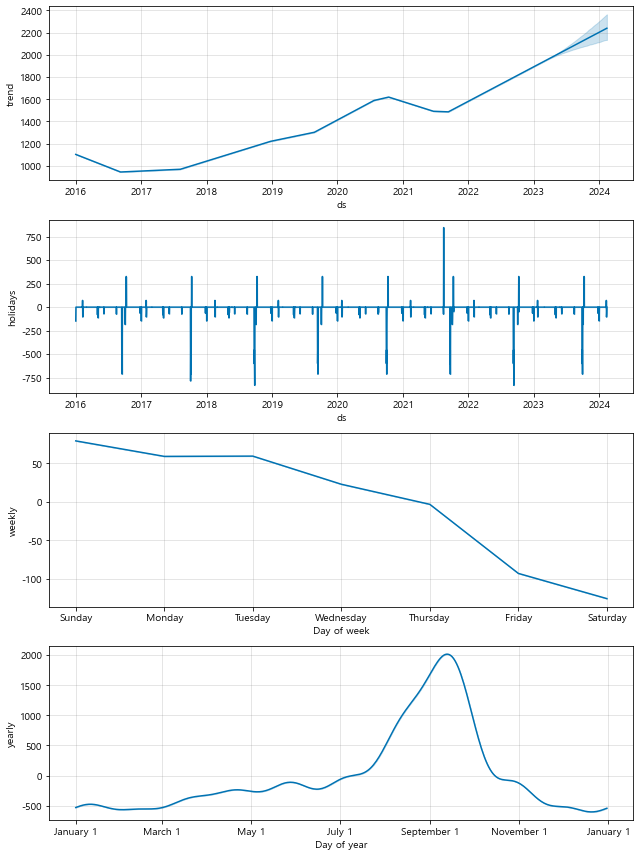

In [303]:
comp = m.plot_components(forecast)

In [304]:
result['error'] = result['y'] - result['yhat'] #실제값 - 예측값범위
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower'] #범위, 불확실성

In [305]:
weight = 1.5
# 본래 abs를 붙여 낮게 나온 이상치도 출력하는 코드였지만, 검색어 특성상 높게 나온 지점만 산출하기 위해 abs 삭제
#비율에 따라, 검색량이 절대적으로 적은(일정 수치 이하) 경우는 가중치를 바꾸도록??
result['anomaly'] = result.apply(lambda x: 'Yes' if((x['error']) > weight*x['uncertainty']) else 'No', axis = 1) #원래는 1.5. 나는 0.4
result['anomaly'] = result.apply(lambda x: 'Low' if (x['anomaly']=='Yes') & (x['y'] < 10000) else 'Yes' if (x['anomaly']=='Yes') & (x['y'] >= 1000) else 'No', axis=1) #10000 이하는 Low로
#result['anomaly'] = np.where(np.abs(x['error']) > 1.5*x['uncertainty']), 'Yes', 'No') #Alternate way

In [306]:
#visualize the anomaly data
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title=new_df.columns[0])
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

In [307]:
result_new = result[result['anomaly']=='Yes']
result_new
#result_new.sort_values(by='error', ascending=False).head(50)

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2022-09-18,48277.50839,3794.65011,2565.69526,4961.35561,44482.85828,2395.66035,Yes
2022-09-19,11099.12738,3731.23067,2551.56759,4886.16203,7367.89671,2334.59444,Yes


In [314]:
final_df

,날짜,계란,포도,배,사과,망고,옥수수,벼,쌀,보리,식약처,식품의약품안전처,식품안전나라,수박,복숭아,오렌지,딸기,크릴오일,참외,양식
0,2016-01-01,937.41280,427.50419,1487.77450,2495.60563,2017.16052,719.66534,157.31755,737.64449,1065.26452,303.14841,170.80191,NaN,566.84258,606.29683,858.00490,2050.62172,13.98378,259.19938,303.14841
1,2016-01-02,791.58193,420.01287,1424.84748,2561.02975,2281.85354,755.12422,149.32681,704.18330,1557.19399,369.07196,213.75209,NaN,522.89356,626.77308,975.86820,2100.56379,6.99189,261.19707,305.14610
2,2016-01-03,891.46609,463.96190,1522.73395,2855.18859,2383.73538,877.98173,159.31523,925.92612,1561.18935,407.02793,240.22139,NaN,575.83216,613.78814,1000.33982,3579.84814,6.99189,258.20054,379.55979
3,2016-01-04,1087.73846,1008.33055,1842.36325,3857.52609,2420.19309,965.87979,265.19243,1082.74425,1572.67603,3174.81789,1210.09655,NaN,1313.97607,778.59699,1120.70023,3054.45748,31.46351,327.62003,576.83100
4,2016-01-05,1054.27726,556.35475,1981.70165,3699.70913,2266.87091,1049.28306,236.72545,1050.28190,1473.79072,3159.33584,1370.91004,NaN,728.65492,801.07093,1099.22513,2876.16426,17.97915,331.61540,562.84722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596,2023-02-09,1432.83821,1030.80449,1787.42697,4576.19259,3827.06143,1255.04442,211.25499,1639.59842,644.25280,2727.83629,978.86473,3030.98470,1280.51488,1437.83242,1630.60884,4553.71866,391.54589,1421.85096,951.39658
2597,2023-02-10,1280.51488,1041.29232,1635.60305,4035.81931,3342.62327,1239.56237,188.28163,1546.20673,660.23427,2391.72611,821.04776,2475.12938,1244.55658,1347.43726,1595.64939,4461.32581,340.60497,1516.24148,1042.29116
2598,2023-02-11,1091.73382,1086.73961,1583.66329,3646.77052,3834.05332,1203.10466,192.27700,1450.31794,625.77424,538.37560,312.13799,590.31536,1317.97143,1244.55658,1536.71774,4241.58067,316.13335,1425.84632,973.87052
2599,2023-02-12,1354.42915,1059.27147,1842.36325,4506.27368,5079.10932,1388.38976,233.72892,1786.42812,689.70010,459.96654,272.68375,506.91209,1365.91583,1503.25654,1809.40148,4520.25747,334.61192,1534.72005,952.39542


In [ ]:
# 뉴스 크롤링을 위한 파일 생성

In [925]:
df_anomaly_key = pd.read_csv('data/anomaly_keyword.csv', index_col='검색어', encoding='cp949')
df_anomaly_key = df_anomaly_key[df_anomaly_key['날짜'].values != '[]']

In [913]:
from datetime import timedelta

df_date = pd.DataFrame(columns=['검색어', '시작일자', '종료일자'])
for i in range(len(df_anomaly_key)):
    anomaly_list = df_anomaly_key['날짜'][i].strip('[]').split()
    anomaly_list = [x[1:11] for x in anomaly_list]
    start_date = []
    end_date = []
    temp_list = []
    for day in anomaly_list:
        day = datetime.strptime(day,"%Y-%m-%d") #날짜에 해당하는 부분만 추출
        if str(day+timedelta(days=1))[:10] in anomaly_list:
            start_date.append(str(day)[:10])
        elif str(day-timedelta(days=1))[:10] in anomaly_list:
            end_date.append(str(day)[:10])
        else:
            start_date.append(str(day)[:10])
            end_date.append(str(day)[:10])
    temp_df = pd.DataFrame([df_anomaly_key.index[i],start_date,end_date]).T
    temp_df.columns = ['검색어', '시작일자', '종료일자']
    df_date = pd.concat([df_date, temp_df])
df_date = df_date.reset_index().drop('index',axis=1)

In [918]:
df_date

,검색어,시작일자,종료일자
0,계란,[2017-08-15],[2017-08-16]
1,포도,[2022-09-18],[2022-09-19]
2,배,[2023-01-30],[2023-01-30]
3,사과,"[2016-02-15, 2018-04-22, 2020-09-14, 2020-09-2...","[2016-02-15, 2018-04-23, 2020-09-14, 2020-09-2..."
4,망고,"[2018-09-17, 2019-06-13, 2022-10-06, 2022-10-07]","[2018-09-17, 2019-06-13, 2022-10-08]"
...,...,...,...
422,트와이닝,[2018-08-05],[2018-08-05]
423,해동,"[2020-01-03, 2020-01-04]",[2020-01-05]
424,홍차,"[2016-05-29, 2016-06-03, 2018-08-02, 2019-02-17]","[2016-05-30, 2016-06-03, 2018-08-02, 2019-02-17]"
425,화장품,[2018-10-28],[2018-10-28]


#연속일자
if multiple_days != []:
    print('시작일: ', multiple_days[0]) # 시작일. i%2==0
    print('종료일: ', multiple_days[1]) # 종료일. i%2==1

multiple_days

# 단독일자
single_day

# 예측 평가??
- https://dining-developer.tistory.com/25

In [ ]:
for search_key in tqdm(final_df.columns[1:]): #'날짜'제외
    new_df = final_df[['날짜', search_key]]
    new_df = new_df.set_index('날짜')
    new_df_prophet = new_df.reset_index()[['날짜', new_df.columns[0]]].rename({'날짜':'ds', new_df.columns[0]:'y'}, axis='columns')

In [76]:
new_df_prophet[(new_df_prophet['ds'] >= '2022-01-01')]

,ds,y
2192,2022-01-01,98.27048
2193,2022-01-02,94.23888
2194,2022-01-03,116.91668
2195,2022-01-04,150.68141
2196,2022-01-05,125.98780
...,...,...
2590,2023-02-03,179.40663
2591,2023-02-04,154.71302
2592,2023-02-05,180.41453
2593,2023-02-06,171.34341


10:12:28 - cmdstanpy - INFO - Chain [1] start processing
10:12:28 - cmdstanpy - INFO - Chain [1] done processing


          ds       yhat  yhat_lower  yhat_upper
0 2022-01-01   95.44726    -1.54326   187.44336
1 2022-01-02  162.96256    63.19549   259.49249
2 2022-01-03  196.74674    97.57683   297.30082
3 2022-01-04  191.05047    90.96698   285.99162
4 2022-01-05  184.48048    89.15917   279.40244


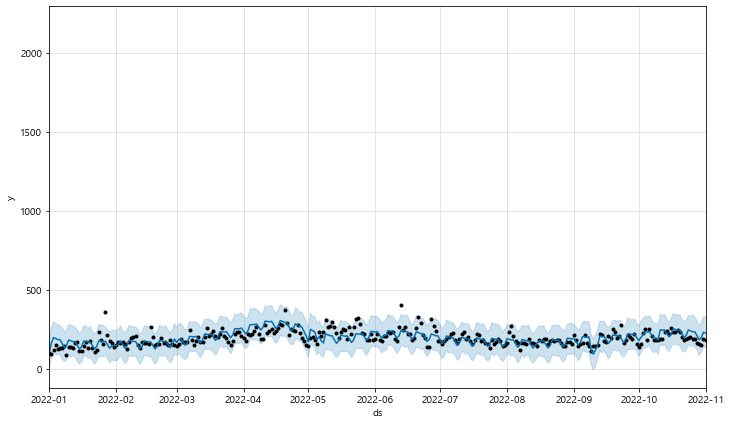

In [77]:
import datetime
# 모델 생성 후 학습
model = Prophet() #seasonality_mode='multiplicative' 승법기법??
model.add_country_holidays(country_name='KR')
# 마지막 12개월 제외시키기
#train = new_df_prophet[(new_df_prophet['ds'] >= '2016-01-01') & (new_df_prophet['ds'] <= '2021-12-31')] 
y_true = new_df_prophet[(new_df_prophet['ds'] >= '2022-01-01')]['y'].values

# 모델 학습
model.fit(new_df_prophet) #학습모델로 평가하는게 맞나?

# train set 마지막 1년 날짜 생성
last_1year = new_df_prophet[(new_df_prophet['ds'] >= '2022-01-01')]['ds']
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

# 예측
forecast = model.predict(last_1year)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

model.plot(forecast)
plt.xlim([datetime.date(2022, 1, 1), datetime.date(2022, 11, 1)])
#plt.ylim([0, 30000])
plt.show()

In [78]:
last_1year.reset_index()['ds']

0     2022-01-01
1     2022-01-02
2     2022-01-03
3     2022-01-04
4     2022-01-05
         ...    
398   2023-02-03
399   2023-02-04
400   2023-02-05
401   2023-02-06
402   2023-02-07
Name: ds, Length: 403, dtype: datetime64[ns]

In [79]:
# 마지막 12개월 제외시키기
train = new_df_prophet[(new_df_prophet['ds'] >= '2016-01-01') & (new_df_prophet['ds'] <= '2021-12-31')] 
y_true = new_df_prophet[(new_df_prophet['ds'] >= '2022-01-01')]['y'].values
# 모델 생성 후 학습
model = Prophet()
model.add_country_holidays(country_name='KR')
model.fit(new_df_prophet) #실제로는 new_df_prophet
# train set 마지막 1년 날짜 생성
last_1year = new_df_prophet[(new_df_prophet['ds'] >= '2022-01-01')]['ds']
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.
forecast = model.predict(last_1year)
y_pred = forecast['yhat'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)*100
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)

17:50:05 - cmdstanpy - INFO - Chain [1] start processing
17:50:05 - cmdstanpy - INFO - Chain [1] done processing


MAE: 62.330
MAPE: 6.813


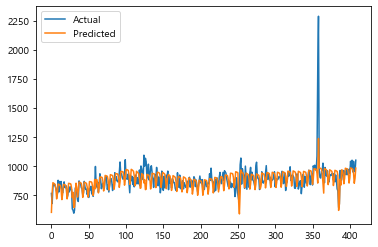

In [90]:
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
#plt.ylim([0, 20000])
plt.show()
## 2022년에 변동점이 있는 경우 예측을 아예 못 함(오히려 못해서 좋음!)

In [82]:
pd.DataFrame(y_pred,y_true).reset_index().corr() #상관 정도에 따라 anomaly 가중치를 설정??(절대량,상관정도 2개의 기준으로 하는게 좋아보임~)

,index,0
index,1.00000,0.56615
0,0.56615,1.00000


In [ ]:
# 교차검증
# - https://gmnam.tistory.com/230